In [1]:
%load_ext autoreload

import sys
import copy
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning")
import json
import collections
import itertools
from functools import partial
import importlib
from tqdm import tqdm

import numpy as onp
from jax.config import config
# config.update("jax_log_compiles", True)
# config.update("jax_enable_x64", True)

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt

import numpy as onp
import jax
import pandas as pd
import haiku as hk
import ot
from jax import tree_util

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import kernel_learning

from jax.experimental import optimizers

key = random.PRNGKey(0)

from jax.scipy.stats import norm
from models import Optimizer
from collections import namedtuple
from typing import Mapping
from models import GradientLearner, SDLearner, Patience, KernelLearner, ScoreLearner

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
@partial(jit, static_argnums=1)
def compute_sd(samples, fun):
    return stein.stein_discrepancy(samples, target.logpdf, fun)

def get_sds(key, n_samples, fun):
    sds = []
    for subkey in random.split(key, 100):
        samples = proposal.sample(n_samples, key=subkey)
        sds.append(compute_sd(samples, fun))
    return sds


# Test

In [3]:
setup = distributions.double_mixture
target, proposal = setup.get()
n_samples = 400
learner = ScoreLearner(target, learning_rate=1e-2, patience=30, sizes=[32, 32, 1])

samples = proposal.sample(n_samples)
validation_samples = proposal.sample(n_samples)

In [4]:
learner.train_sampling_every_time(proposal=proposal, progress_bar=True, n_steps=2000, batch_size=n_samples)
# learner.train(samples, validation_samples, progress_bar=True, n_steps=1000)

100%|██████████| 2000/2000 [00:11<00:00, 179.41it/s]


# Evaluate Score matchers

In [5]:
v = learner.get_field()
def opt_g(x):
    """True grad(KL)"""
    return grad(lambda x: proposal.logpdf(x) - target.logpdf(x))(x) / (2*learner.lambda_reg)

def true_score(x):
    return grad(proposal.logpdf)(x) / (2*learner.lambda_reg)

In [6]:
s = proposal.sample(10_000)
def true_div(x):
    return np.inner(true_score(x), grad(proposal.logpdf)(x))
true_divergence_mean = -np.mean(vmap(true_div)(s))
optimal_loss = true_divergence_mean + learner.lambda_reg*utils.l2_norm(s, true_score)**2

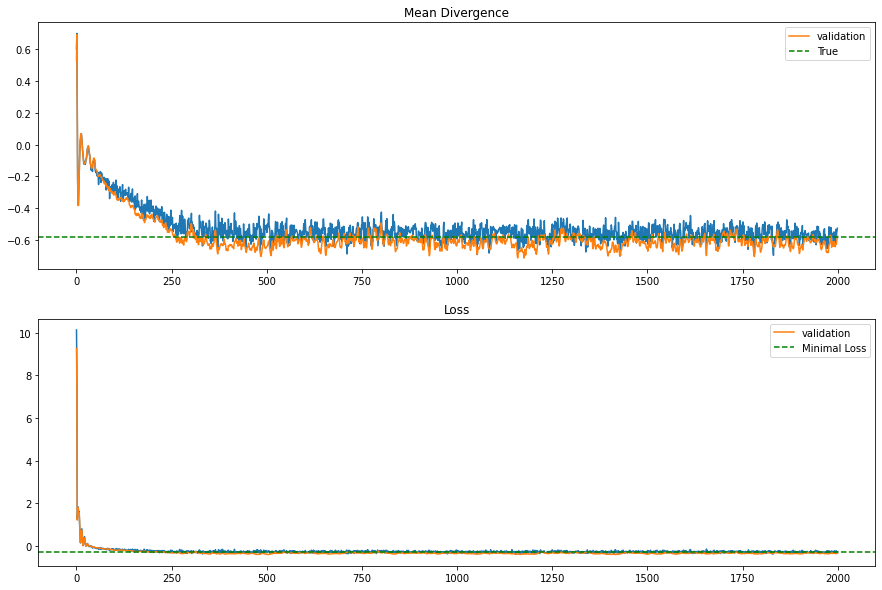

In [7]:
fig, axs = plt.subplots(2, figsize=[15, 10])
ax = axs[0]
ax.plot(learner.rundata["training_div"])
ax.plot(learner.rundata["validation_div"], label="validation")
ax.axhline(y=true_divergence_mean, linestyle="--", color="green", label="True")
ax.set_title("Mean Divergence")
ax.legend()

ax=axs[1]
ax.plot(learner.rundata["training_loss"])
ax.plot(learner.rundata["validation_loss"], label="validation")
ax.axhline(y=optimal_loss, linestyle="--", color="green", label="Minimal Loss")
ax.set_title("Loss")
ax.legend()

In [8]:
print(utils.l2_norm(s, true_score))
print(utils.l2_norm(s, learner.get_score()))

0.759854
0.70221937


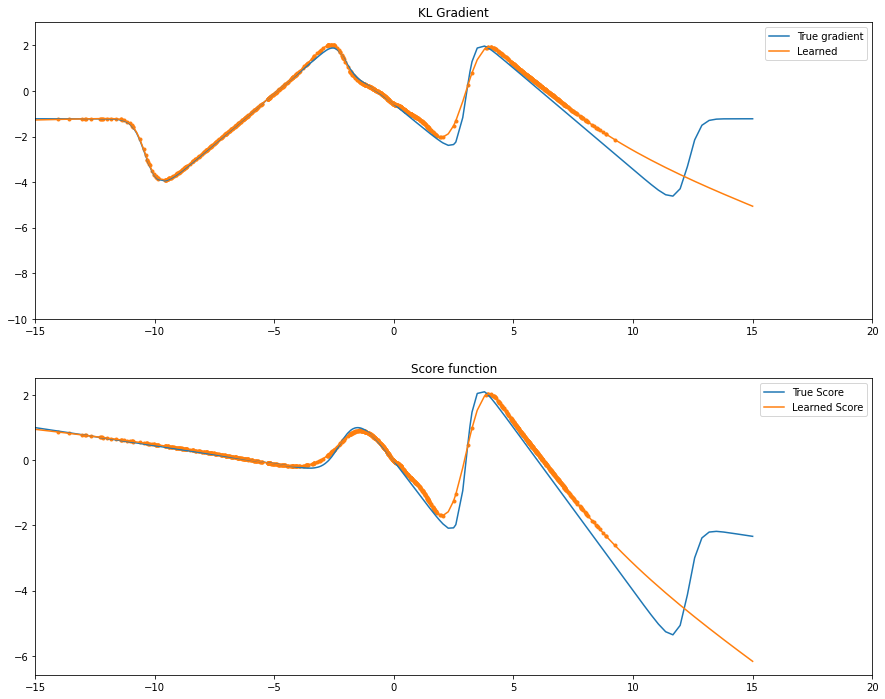

In [11]:
samples = proposal.sample(1000)
samples = np.sort(samples, axis=0)
xlim = (-15, 20)

# plot the learned gradient
grid = np.linspace(-15, 15, 100)
full_grid = np.concatenate([grid, np.squeeze(samples)]).sort()
full_grid = np.expand_dims(full_grid, axis=1)

fig, axs = plt.subplots(2, figsize=[15,12])
ax = axs[0]
ax.plot(full_grid, vmap(opt_g)(full_grid), label="True gradient")
ax.plot(full_grid, vmap(v)(full_grid), label="Learned")
ax.scatter(samples, vmap(v)(samples), marker=".", color="tab:orange")
ax.set_ylim((-10,3))
ax.set_xlim(xlim)
ax.set_title("KL Gradient")
ax.legend()

ax = axs[1]
learned_score = learner.get_score()
ax.plot(full_grid, vmap(true_score)(full_grid), label="True Score")
ax.plot(full_grid, vmap(learned_score)(full_grid), label="Learned Score")
ax.scatter(samples, vmap(learned_score)(samples), marker=".", color="tab:orange")
ax.set_xlim(xlim)
ax.set_title("Score function")
ax.legend()

In [10]:
sldfkjlk

NameError: name 'sldfkjlk' is not defined

# Evaluate Stein discrepancies

In [ ]:
v = learner.get_field(samples)
def opt_g(x):
    return grad(lambda x: target.logpdf(x) - proposal.logpdf(x))(x) / (2*learner.lambda_reg)

opt_mean, opt_std = stein.get_optimal_sd(key, learner.lambda_reg, target, proposal)
# optimal_loss = -opt_mean + learner.lambda_reg * utils.l2_norm(proposal.sample(10_000), opt_g)
learned_sds = get_sds(key, 400, v)

def true_sd(x, gfield):
    return np.inner(gfield(x), opt_g(x))

true_learned_sds = np.mean(vmap(true_sd, (0, None))(proposal.sample(10_000), v))

In [ ]:
fig, axs = plt.subplots(2, figsize=[15, 10])
ax = axs[0]
ax.plot(learner.rundata["training_ksd"])
ax.plot(learner.rundata["validation_ksd"], label="validation")
ax.errorbar(x=0,                    y=opt_mean,              yerr=opt_std,              capsize=10, color="green", marker="o")
ax.errorbar(x=learner.step_counter, y=onp.mean(learned_sds), yerr=onp.std(learned_sds), capsize=10, color="tab:blue", marker="o")
ax.axhline(y=opt_mean, color="green", linestyle="--")
ax.axhline(y=true_learned_sds, color="tab:blue", linestyle="--") # if blue line does not batch blue errorbar, then we're badly overfitting
ax.legend()

ax=axs[1]
ax.plot(learner.rundata["training_loss"])
ax.plot(learner.rundata["validation_loss"], label="validation")
# ax.axhline(y=optimal_loss, color="green", linestyle="--")
ax.legend()
# ax.set_ylim((-2,0))

In [ ]:
fig, axs = plt.subplots(2, figsize=[15, 10])
ax = axs[0]
ax.plot(learner.rundata["training_ksd"])
ax.plot(learner.rundata["validation_ksd"], label="validation")
ax.errorbar(x=0,                    y=opt_mean,              yerr=opt_std,              capsize=10, color="green", marker="o")
ax.errorbar(x=learner.step_counter, y=onp.mean(learned_sds), yerr=onp.std(learned_sds), capsize=10, color="tab:blue", marker="o")
ax.axhline(y=opt_mean, color="green", linestyle="--")
ax.axhline(y=true_learned_sds, color="tab:blue", linestyle="--") # if blue line does not batch blue errorbar, then we're badly overfitting
ax.legend()

ax=axs[1]
ax.plot(learner.rundata["training_loss"])
ax.plot(learner.rundata["validation_loss"], label="validation")
# ax.axhline(y=optimal_loss, color="green", linestyle="--")
ax.legend()
# ax.set_ylim((-2,0))

In [ ]:
plt.subplots(figsize=[15, 7])
loss_val = onp.array(learner.rundata["validation_loss"])
sort_idx = onp.argsort(loss_val)

plt.plot(loss_val)
idx = sort_idx[:155]
imin = idx[0]
plt.scatter(idx, loss_val[idx], label="min")
plt.scatter(imin, loss_val[imin], label="min")
# plt.ylim((-.5, 0.5))

In [ ]:
samples = proposal.sample(1000)
samples = np.sort(samples, axis=0)

xlim = (-15, 20)
# plot the stein gradient
scale_rbf=15
grid_n = 100
grid = np.linspace(-15, 15, grid_n)
full_grid = np.concatenate([grid, np.squeeze(samples)]).sort()
full_grid = np.expand_dims(full_grid, axis=1)

fig, ax = plt.subplots(figsize=[12,7])
plt.plot(full_grid, vmap(opt_g)(full_grid))
plt.plot(full_grid, vmap(v)(full_grid))
plt.scatter(samples, vmap(v)(samples), marker=".", color="tab:orange")
# plt.ylim((-10,3))
plt.xlim(xlim)

In [ ]:
fig, ax = plt.subplots(figsize=[12,10])
ax.hist(samples[:,0], density=True, bins=25)
ax.set_xlim(xlim)

def mul(x):
    x = np.array(x)
    x = x.reshape((1,))
    return np.squeeze(v(x) * proposal.pdf(np.squeeze(x)))

plot.plot_fun(mul, lims=xlim, ax=ax, label="g(x)q(x)")
ax.legend()


def gg(x):
    return -grad(utils.accept_scalar(v))(x)
def gg_true(x):
    return -grad(opt_g)(x)

# plot.plot_fun(gg, lims=xlim)
# plot.plot_fun(gg_true, lims=xlim)

In [ ]:
print(utils.l2_norm(proposal.sample(10000), v))
print(utils.l2_norm(proposal.sample(10000), opt_g))
# _ = plt.plot(learner.rundata["l2_norm"])